In [1]:
pip install pandas numpy matplotlib seaborn plotly statsmodels scikit-learn prophet tensorflow keras


In [5]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# Forecasting Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Time Series Specific
from statsmodels.tsa.stattools import adfuller


In [7]:
df1 = pd.read_csv(r"C:\Users\LENOVO\OneDrive\Documents\wholestock\historical_stocks.csv")
df2 = pd.read_csv(r"C:\Users\LENOVO\OneDrive\Documents\wholestock\stocks.csv")

# Convert Date to datetime
df2['Date'] = pd.to_datetime(df2['Date'])

# Set Date as index for time series models
df2.set_index('Date', inplace=True)

df2.head()


,Open,High,Low,Close,Volume
Date,,,,,
2024-01-01,351.949281,483.615782,462.037159,395.720642,16115
2024-01-02,346.182519,275.020934,487.727355,464.805495,28933
2024-01-03,354.081553,247.607139,354.354190,312.066656,4320
2024-01-04,499.563617,408.710096,279.817282,446.952441,41380
2024-01-05,410.160460,198.047225,266.921714,395.556332,41334


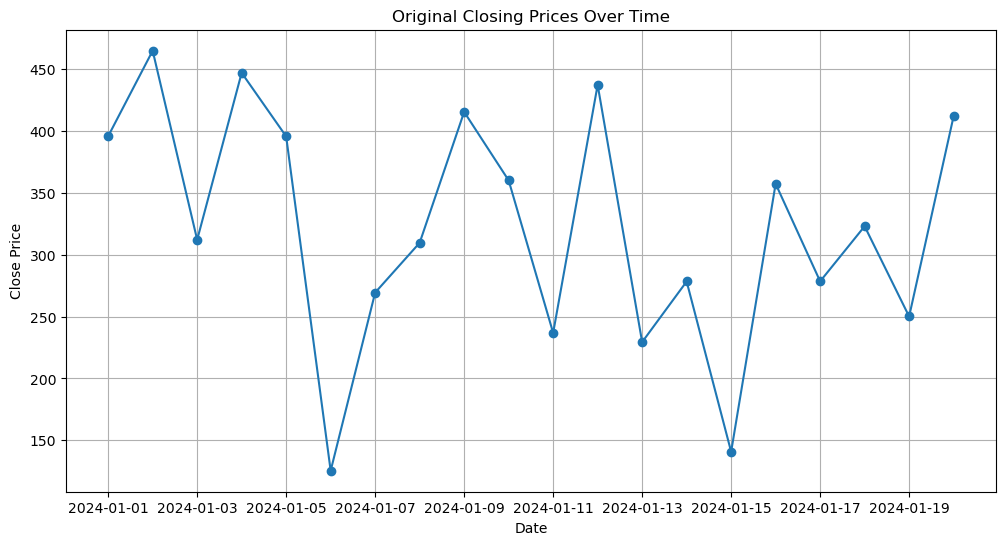

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2['Close'], marker='o')
plt.title("Original Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid()
plt.show()


In [11]:
result = adfuller(df2['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.1443414521173096
p-value: 0.6970691995907663


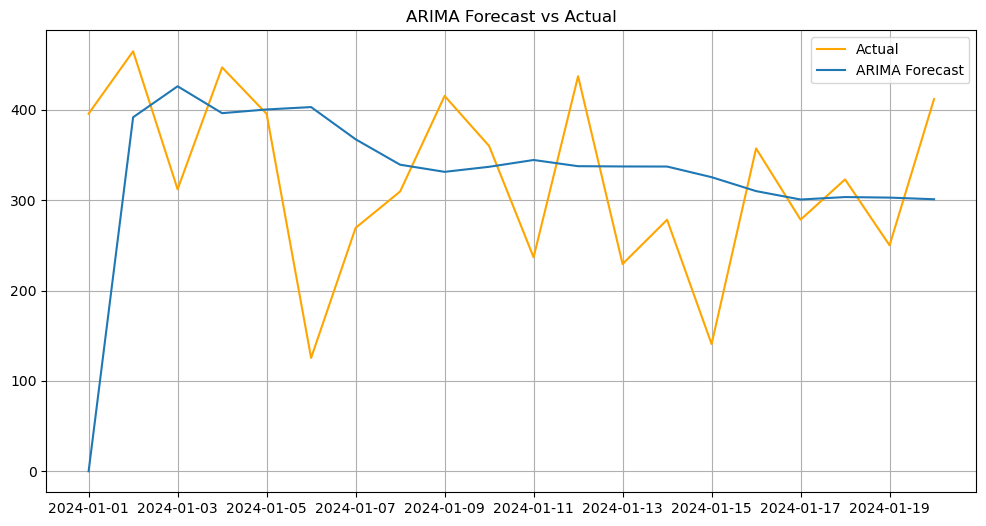

In [39]:
# Set frequency to daily
df2 = df2.asfreq('D')

# Now fit ARIMA
model_arima = ARIMA(df2['Close'], order=(1,1,1))
result_arima = model_arima.fit()
forecast_arima = result_arima.predict(start=0, end=len(df2)-1, typ='levels')

plt.figure(figsize=(12,6))
plt.plot(df2['Close'], label='Actual',color='orange')
plt.plot(forecast_arima, label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.grid()
plt.show()


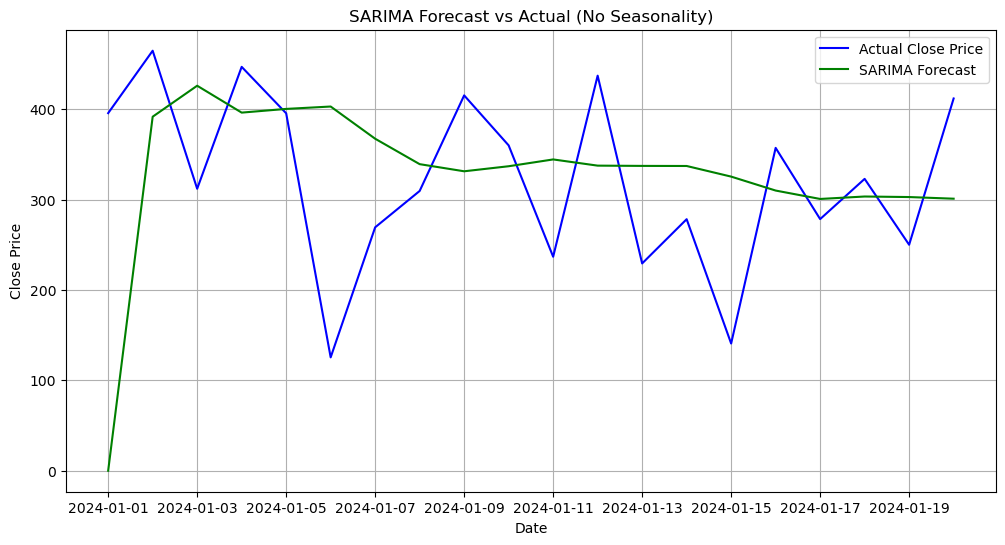

In [21]:
# Set frequency to daily to avoid frequency warnings
df2 = df2.asfreq('D')

# SARIMA model (without seasonality)
model_sarima = SARIMAX(df2['Close'],
                       order=(1,1,1),
                       seasonal_order=(0,0,0,0))

# Fit the SARIMA model
result_sarima = model_sarima.fit(disp=False)

# Forecast for the entire data range
forecast_sarima = result_sarima.predict(start=0, end=len(df2)-1, typ='levels')

# Plot the actual vs forecasted data
plt.figure(figsize=(12,6))
plt.plot(df2['Close'], label='Actual Close Price', color='blue')
plt.plot(forecast_sarima, label='SARIMA Forecast', color='green')
plt.title("SARIMA Forecast vs Actual (No Seasonality)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


09:29:59 - cmdstanpy - INFO - Chain [1] start processing
09:30:00 - cmdstanpy - INFO - Chain [1] done processing


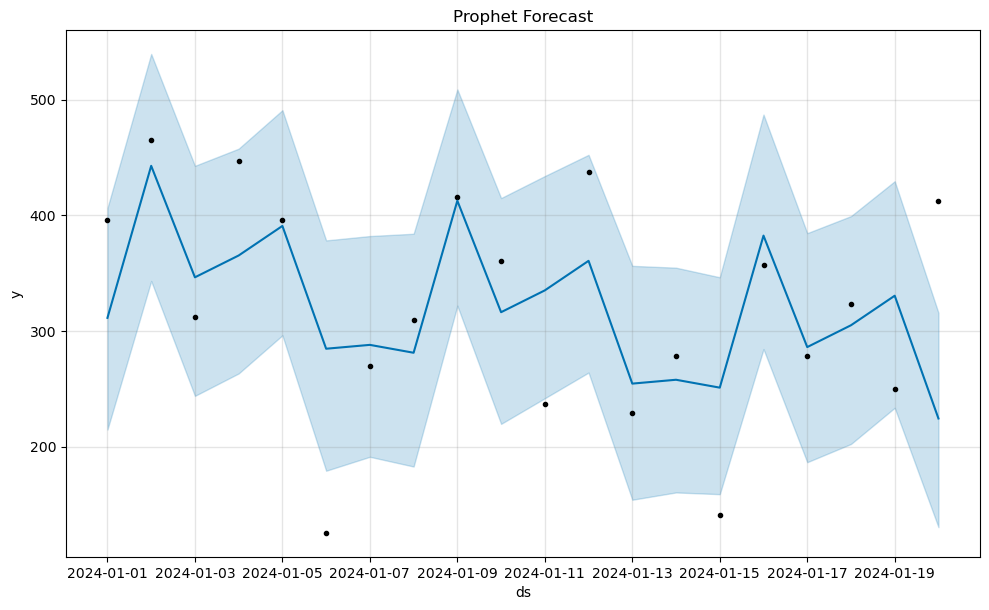

In [23]:
df_prophet = df2.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=0)
forecast_prophet = model_prophet.predict(future)

fig = model_prophet.plot(forecast_prophet)
plt.title("Prophet Forecast")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


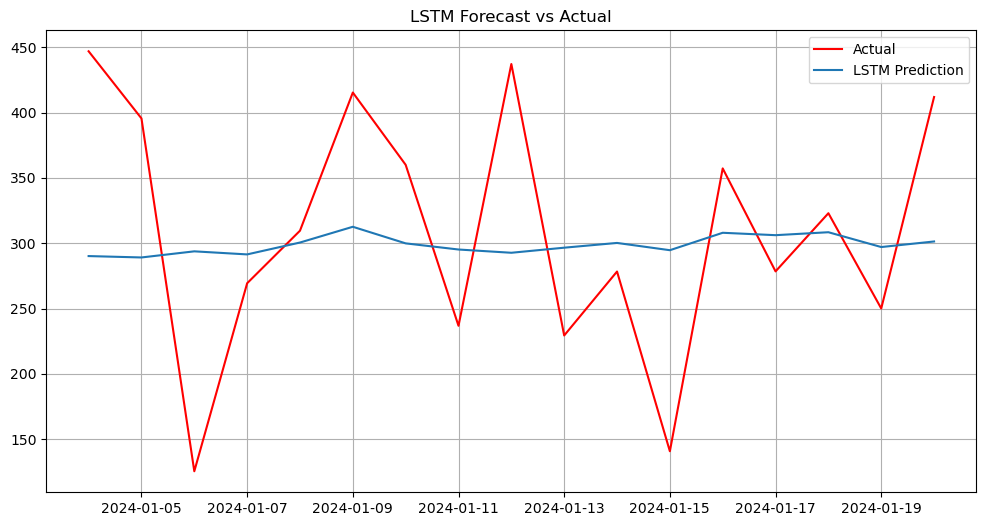

In [41]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df2[['Close']])

# Prepare LSTM sequences
X, y = [], []
for i in range(3, len(scaled_data)):
    X.append(scaled_data[i-3:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Clean LSTM Model (Warning Free)
model_lstm = Sequential()
model_lstm.add(Input(shape=(X.shape[1], 1)))   # 
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X, y, epochs=50, batch_size=1, verbose=0)

# Predict
predictions = model_lstm.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df2.index[3:], df2['Close'][3:], label='Actual',color='red')
plt.plot(df2.index[3:], predictions, label='LSTM Prediction')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.grid()
plt.show()


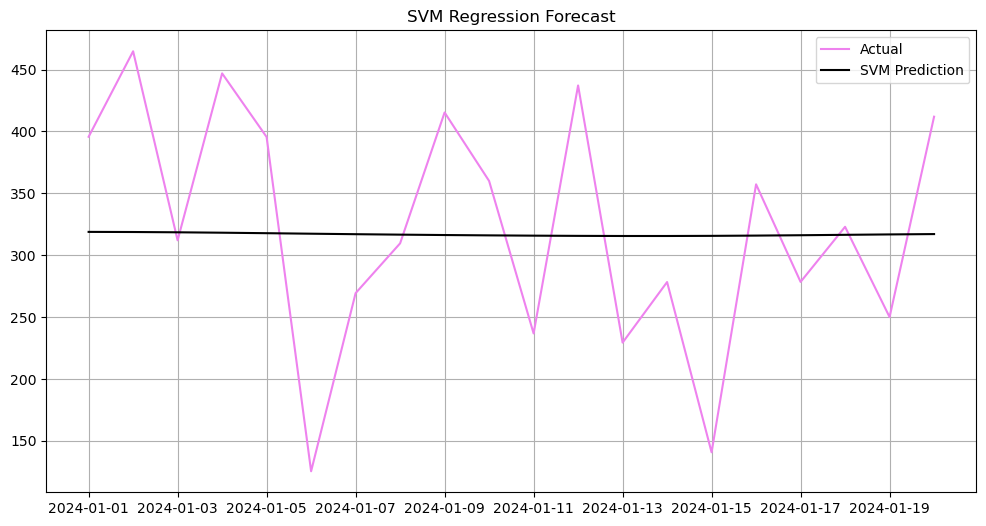

In [45]:
X_svm = np.array(range(len(df2))).reshape(-1,1)
y_svm = df2['Close'].values

model_svm = SVR(kernel='rbf')
model_svm.fit(X_svm, y_svm)
pred_svm = model_svm.predict(X_svm)

plt.figure(figsize=(12,6))
plt.plot(df2.index, df2['Close'], label='Actual',color='violet')
plt.plot(df2.index, pred_svm, label='SVM Prediction',color='black')
plt.title("SVM Regression Forecast")
plt.legend()
plt.grid()
plt.show()


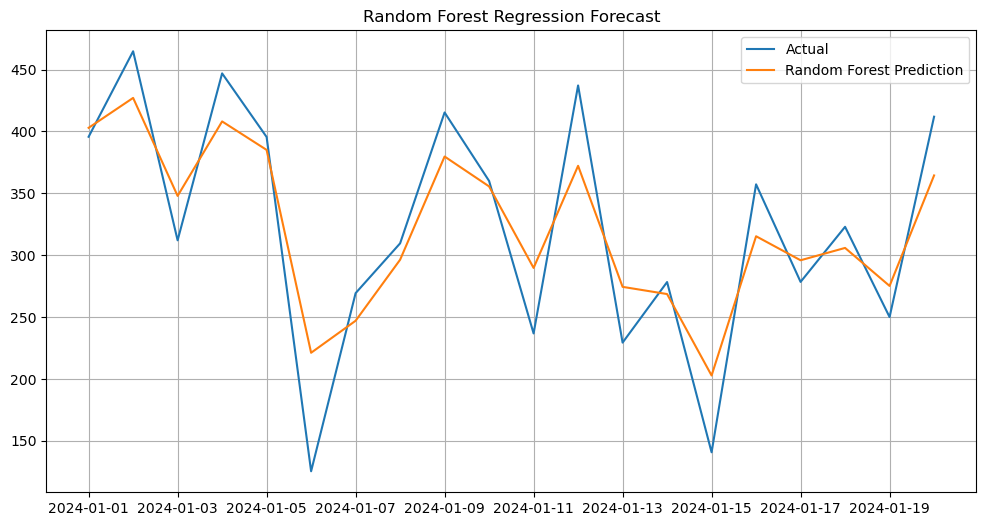

In [33]:
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_svm, y_svm)
pred_rf = model_rf.predict(X_svm)

plt.figure(figsize=(12,6))
plt.plot(df2.index, df2['Close'], label='Actual')
plt.plot(df2.index, pred_rf, label='Random Forest Prediction')
plt.title("Random Forest Regression Forecast")
plt.legend()
plt.grid()
plt.show()


In [ ]:
vs 